2) Learn the following models on XOR dataset (refer to Tensorflow Playground and generate the dataset on your own containing 200 training instances and 200 test instances) such that all these models achieve similar results (good). The definition of good is left subjective – but you would expect the classifier to capture the shape of the XOR function.

a. MLP

b. MLP w/ L1 regularization (you may vary the penalty coefficient by choose the best one using a validation dataset)

c. MLP w/ L2 regularization (you may vary the penalty coefficient by choose the best one using a validation dataset)

d. learn logistic regression models on the same data with additional features (such as x1*x2, x1^2, etc.)

Show the decision surface and comment on the plots obtained for different models. [2 marks]


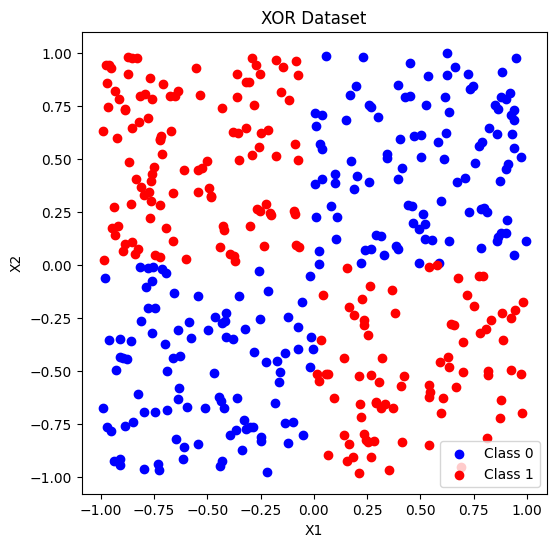

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch

torch.manual_seed(42)
np.random.seed(42)

def generate_XOR_data(n_samples):
  X = np.random.rand(n_samples, 2) * 2 - 1  # Random points between -1 and 1
  y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int)  # XOR label
  return X, y

X, y = generate_XOR_data(400)

plt.figure(figsize=(6, 6))
plt.scatter(X[y==0,0], X[y==0,1], c='b', label='Class 0')
plt.scatter(X[y==1,0], X[y==1,1], c='r', label='Class 1')

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('XOR Dataset')
plt.legend()
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

XOR is a straightforward binary classification problem, where the output is either 0 or 1 based on the exclusive OR logic. It’s a balanced dataset.More complex metrics like F1-score, precision, and recall become more relevant in scenarios with imbalanced datasets, multiclass outputs, or when there's a need to handle specific kinds of misclassification errors. But XOR does not pose these complexities.

We use `optimizer.zero_grad()` at the beginning of each training step to reset the gradients of all model parameters to zero. This is necessary because, by default, PyTorch accumulates gradients on each `backward()` call. Without zeroing out the gradients, they would keep accumulating, which would result in incorrect gradient calculations and unstable training.

Early stopping at epoch 162 with best validation loss of 0.0765
Test Accuracy: 0.9750


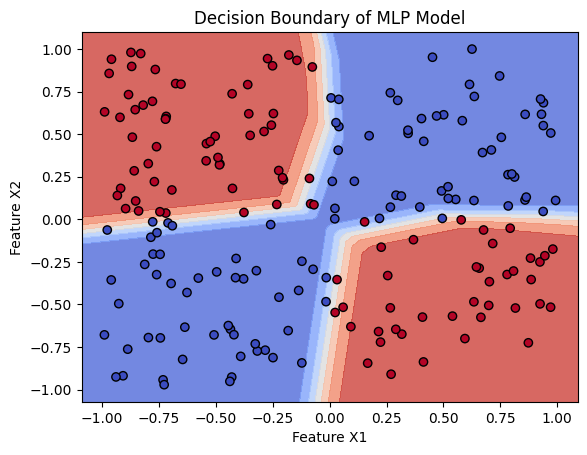

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

np.random.seed(42)
torch.manual_seed(42)

# MLP Model Class
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 8)
        self.fc2 = nn.Linear(8, 8)
        self.fc3 = nn.Linear(8, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

# Function to train model with early stopping based on validation loss
def train_model(model, X_train, y_train, X_val, y_val, epochs=200, lr=0.01, patience=25):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    best_val_loss = float('inf')  # Initialize best validation loss to infinity
    early_stopping_counter = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Validate
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()  # Calculate validation loss

        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), 'best_model_mlp.pth')  # Save model checkpoint
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1} with best validation loss of {best_val_loss:.4f}')
            break

    return best_val_loss

# Function to evaluate model
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = (outputs > 0.5).float()
        accuracy = (predicted.eq(y_test).sum().item()) / y_test.size(0)
    return accuracy

# Function to plot decision boundary
def plot_decision_boundary_mlp(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict on the grid
    with torch.no_grad():
        Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).numpy()
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
    plt.title('Decision Boundary of MLP Model')
    plt.xlabel('Feature X1')
    plt.ylabel('Feature X2')
    plt.show()

# Main execution
mlp_model = MLP(input_size=2, output_size=1)
val_acc = train_model(mlp_model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

# Evaluate the model
mlp_model.load_state_dict(torch.load('best_model_mlp.pth', weights_only=True))  # Load the best model
test_acc = evaluate_model(mlp_model, X_test_tensor, y_test_tensor)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot the decision boundary of the trained MLP model
plot_decision_boundary_mlp(mlp_model, X_test, y_test)



\
$\text{L1 Loss} = \lambda \sum_{i=1}^{n} |w_i|$



Early stopping at epoch 133 due to no improvement.
L1 Penalty: 9.999999974752427e-07, Validation Loss: 0.0781259536743164
L1 Penalty: 0.004000999964773655, Validation Loss: 0.2574955224990845
Early stopping at epoch 117 due to no improvement.
L1 Penalty: 0.008001000620424747, Validation Loss: 0.6935049295425415
Early stopping at epoch 133 due to no improvement.
L1 Penalty: 0.012001000344753265, Validation Loss: 0.6943186521530151
Early stopping at epoch 135 due to no improvement.
L1 Penalty: 0.016001001000404358, Validation Loss: 0.6949663162231445
Early stopping at epoch 144 due to no improvement.
L1 Penalty: 0.02000100165605545, Validation Loss: 0.6953166723251343
Early stopping at epoch 142 due to no improvement.
L1 Penalty: 0.024001000449061394, Validation Loss: 0.6957122683525085
Early stopping at epoch 127 due to no improvement.
L1 Penalty: 0.028001001104712486, Validation Loss: 0.6964977383613586
Early stopping at epoch 133 due to no improvement.
L1 Penalty: 0.03200099989771843,

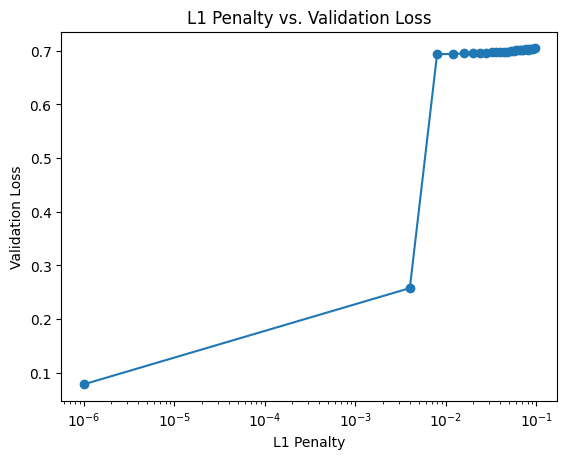

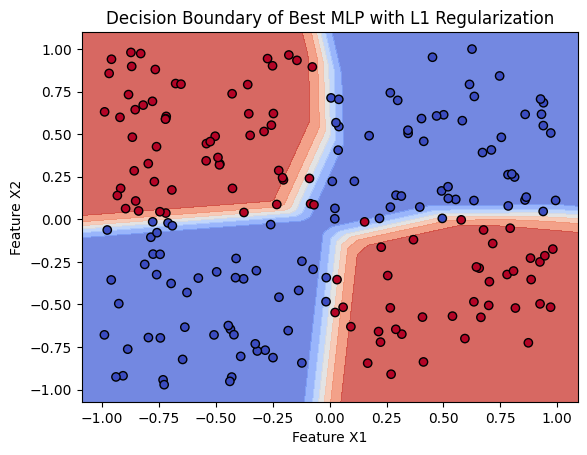

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
torch.manual_seed(42)

# Define the MLP model with L1 regularization
class MLP_L1(nn.Module):
    def __init__(self, input_size, l1_penalty):
        super(MLP_L1, self).__init__()
        self.fc1 = nn.Linear(input_size, 8)
        self.fc2 = nn.Linear(8, 8)
        self.fc3 = nn.Linear(8, 1)
        self.l1_penalty = l1_penalty

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

    def l1_loss(self):
        l1_norm = sum(torch.norm(param, 1) for param in self.parameters())
        return self.l1_penalty * l1_norm

# Function to train and evaluate the model
def train_and_evaluate(l1_penalty, X_train, y_train, X_val, y_val, epochs=200, batch_size=32, patience=15):
    model = MLP_L1(input_size=2, l1_penalty=l1_penalty)
    criterion = nn.BCELoss()  # Binary cross-entropy loss
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    best_val_loss = float("inf")
    best_model_state = None
    wait = 0  # Counter for early stopping

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        l1_loss = model.l1_loss()
        total_loss = loss + l1_loss
        total_loss.backward()
        optimizer.step()

        # Training accuracy (optional)
        train_predicted = (outputs > 0.5).float()
        train_acc = (train_predicted.eq(y_train).sum().item()) / y_train.size(0)

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val) + model.l1_loss()

        # Track the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1  # Increment wait counter

        # Early stopping
        if wait >= patience:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement.")
            break

    # Load the best model
    model.load_state_dict(best_model_state)
    return best_val_loss, model  # Return best validation loss and the model

# Set the L1 penalties and other parameters
l1_penalties = np.arange(1e-6, 0.1, 4e-3, dtype=np.float32)
best_val_loss = float("inf")
best_model_l1 = None
best_l1_penalty = None

val_losses = []
penalties = []

# Iterate over each L1 penalty and train the model
for l1_penalty in l1_penalties:
    val_loss, model = train_and_evaluate(
        l1_penalty, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor
    )
    val_losses.append(val_loss)
    penalties.append(l1_penalty)

    # Print the validation loss for the current penalty
    print(f"L1 Penalty: {l1_penalty}, Validation Loss: {val_loss}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_l1 = model
        best_l1_penalty = l1_penalty

# Evaluate the best model on the test set
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_predicted = (test_outputs > 0.5).float()
        test_acc = (test_predicted.eq(y_test).sum().item()) / y_test.size(0)
    return test_acc

if best_model_l1 is not None:  # Check if a model was trained
    test_acc = evaluate_model(best_model_l1, X_test_tensor, y_test_tensor)
    print(f"Best L1 Penalty: {best_l1_penalty}, Test Accuracy: {test_acc}")
else:
    print("No model was trained successfully.")

# Plot L1 penalty vs. validation loss
plt.plot(penalties, val_losses, marker='o')
plt.xlabel('L1 Penalty')
plt.ylabel('Validation Loss')
plt.title('L1 Penalty vs. Validation Loss')
plt.xscale('log')  # Use log scale for better visualization
plt.show()

# Plot decision boundary of best model
def plot_decision_boundary_l1(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    with torch.no_grad():
        Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).numpy()
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
    plt.title('Decision Boundary of Best MLP with L1 Regularization')
    plt.xlabel('Feature X1')
    plt.ylabel('Feature X2')
    plt.show()

if best_model_l1 is not None:  # Check if a model was trained successfully
    plot_decision_boundary_l1(best_model_l1, X_test_tensor, y_test_tensor)
else:
    print("No model was trained successfully.")

Early stopping at epoch 136 due to no improvement.
Early stopping at epoch 184 due to no improvement.
Early stopping at epoch 156 due to no improvement.
Early stopping at epoch 126 due to no improvement.
Early stopping at epoch 160 due to no improvement.
Early stopping at epoch 182 due to no improvement.
Early stopping at epoch 141 due to no improvement.
Early stopping at epoch 159 due to no improvement.
Early stopping at epoch 168 due to no improvement.
Early stopping at epoch 172 due to no improvement.
Early stopping at epoch 155 due to no improvement.
Early stopping at epoch 169 due to no improvement.
Early stopping at epoch 169 due to no improvement.
Early stopping at epoch 129 due to no improvement.
Early stopping at epoch 136 due to no improvement.
Early stopping at epoch 140 due to no improvement.
Early stopping at epoch 139 due to no improvement.
Early stopping at epoch 195 due to no improvement.
Early stopping at epoch 119 due to no improvement.
Best L2 Penalty: 9.999999974752

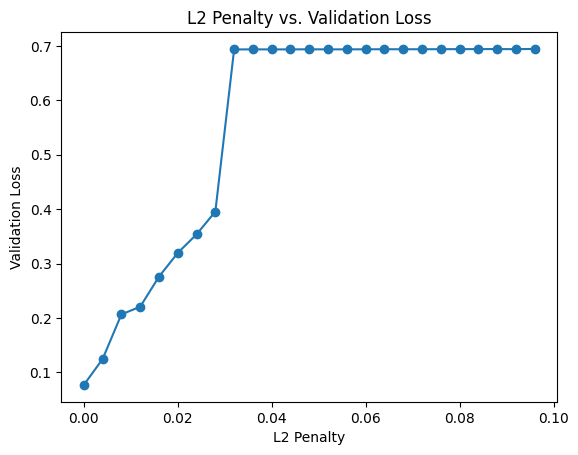

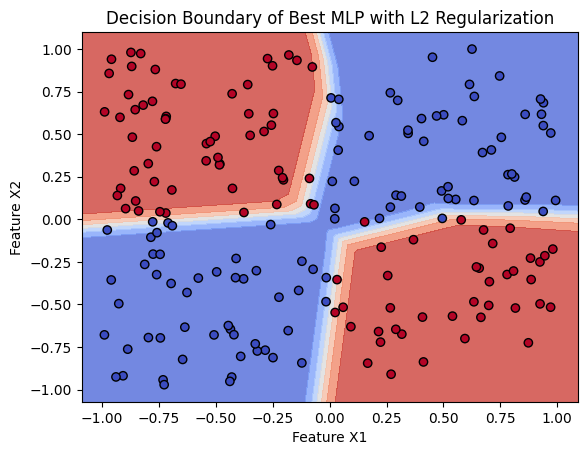

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
torch.manual_seed(42)

# Define the MLP model with L2 regularization
class MLP_L2(nn.Module):
    def __init__(self, input_size, l2_penalty):
        super(MLP_L2, self).__init__()
        self.fc1 = nn.Linear(input_size, 8)
        self.fc2 = nn.Linear(8, 8)
        self.fc3 = nn.Linear(8, 1)
        self.l2_penalty = l2_penalty

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

    def l2_loss(self):
        l2_norm = sum(torch.norm(param, 2) for param in self.parameters())
        return self.l2_penalty * l2_norm

# Function to train and evaluate the model
def train_and_evaluate(l2_penalty, X_train, y_train, X_val, y_val, epochs=200, batch_size=32, patience=15):
    model = MLP_L2(input_size=2, l2_penalty=l2_penalty)
    criterion = nn.BCELoss()  # Binary cross-entropy loss
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    best_val_loss = float("inf")  # Initialize best_val_loss here
    best_model_state = None
    wait = 0  # Counter for early stopping

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        l2_loss = model.l2_loss()
        total_loss = loss + l2_loss
        total_loss.backward()
        optimizer.step()

        # Training accuracy
        train_predicted = (outputs > 0.5).float()
        train_acc = (train_predicted.eq(y_train).sum().item()) / y_train.size(0)

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val) + model.l2_loss()

        # Track the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1  # Increment wait counter

        # Early stopping
        if wait >= patience:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement.")
            break

    # Load the best model
    model.load_state_dict(best_model_state)
    return best_val_loss, total_loss.item(), model  # Return best_val_loss instead of val_acc

# Set the L2 penalties and other parameters
l2_penalties = np.arange(1e-6, 0.1, 4e-3, dtype=np.float32)
best_val_loss = float("inf")
best_model_l2 = None
best_l2_penalty = None

val_losses = []
penalties = []

# Iterate over each L2 penalty and train the model
for l2_penalty in l2_penalties:
    val_loss, _, model = train_and_evaluate(
        l2_penalty, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor
    )
    val_losses.append(val_loss)
    penalties.append(l2_penalty)

    # Print the losses for the current penalty
    # print(f"L2 Penalty: {l2_penalty}, Validation Loss: {val_loss}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_l2 = model
        best_l2_penalty = l2_penalty

# Evaluate the best model on the test set
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_predicted = (test_outputs > 0.5).float()
        test_acc = (test_predicted.eq(y_test).sum().item()) / y_test.size(0)
    return test_acc

test_acc = evaluate_model(best_model_l2, X_test_tensor, y_test_tensor)
print(f"Best L2 Penalty: {best_l2_penalty}, Test Accuracy: {test_acc}")

# Plot L2 penalty vs. validation loss
plt.plot(penalties, val_losses, marker='o')
plt.xlabel('L2 Penalty')
plt.ylabel('Validation Loss')
plt.title('L2 Penalty vs. Validation Loss')
plt.show()

# Plot decision boundary of best model
def plot_decision_boundary_l2(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    with torch.no_grad():
        Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).numpy()
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
    plt.xlabel('Feature X1')
    plt.ylabel('Feature X2')
    plt.title('Decision Boundary of Best MLP with L2 Regularization')
    plt.show()

plot_decision_boundary_l2(best_model_l2, X_test_tensor, y_test_tensor)

Epoch [0/500], Loss: 1.0312, Validation Loss: 0.7818
Epoch [10/500], Loss: 0.9208, Validation Loss: 0.6991
Epoch [20/500], Loss: 0.8395, Validation Loss: 0.6437
Epoch [30/500], Loss: 0.7712, Validation Loss: 0.5982
Epoch [40/500], Loss: 0.7135, Validation Loss: 0.5592
Epoch [50/500], Loss: 0.6646, Validation Loss: 0.5254
Epoch [60/500], Loss: 0.6232, Validation Loss: 0.4965
Epoch [70/500], Loss: 0.5880, Validation Loss: 0.4709
Epoch [80/500], Loss: 0.5579, Validation Loss: 0.4488
Epoch [90/500], Loss: 0.5315, Validation Loss: 0.4291
Epoch [100/500], Loss: 0.5086, Validation Loss: 0.4117
Epoch [110/500], Loss: 0.4882, Validation Loss: 0.3961
Epoch [120/500], Loss: 0.4702, Validation Loss: 0.3820
Epoch [130/500], Loss: 0.4540, Validation Loss: 0.3694
Epoch [140/500], Loss: 0.4393, Validation Loss: 0.3576
Epoch [150/500], Loss: 0.4259, Validation Loss: 0.3469
Epoch [160/500], Loss: 0.4136, Validation Loss: 0.3371
Epoch [170/500], Loss: 0.4024, Validation Loss: 0.3280
Epoch [180/500], Loss

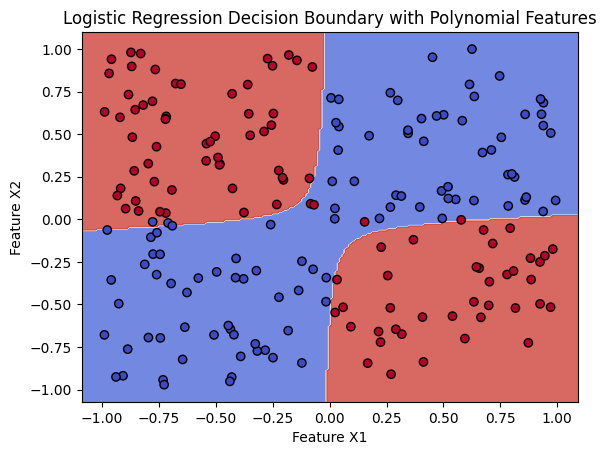

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate XOR data (already done in previous code)
torch.manual_seed(42)
np.random.seed(42)

# Add polynomial features (x1, x2, x1 * x2, x1^2, x2^2)
X_train_poly = torch.column_stack((X_train_tensor[:, 0],               # x1
                                   X_train_tensor[:, 1],               # x2
                                   X_train_tensor[:, 0] * X_train_tensor[:, 1],  # x1 * x2
                                   X_train_tensor[:, 0]**2,            # x1^2
                                   X_train_tensor[:, 1]**2))           # x2^2
X_val_poly = torch.column_stack((X_val_tensor[:, 0],
                                 X_val_tensor[:, 1],
                                 X_val_tensor[:, 0] * X_val_tensor[:, 1],
                                 X_val_tensor[:, 0]**2,
                                 X_val_tensor[:, 1]**2))
X_test_poly = torch.column_stack((X_test_tensor[:, 0],
                                  X_test_tensor[:, 1],
                                  X_test_tensor[:, 0] * X_test_tensor[:, 1],
                                  X_test_tensor[:, 0]**2,
                                  X_test_tensor[:, 1]**2))

# Define the model with 5 input features
class LogisticRegressionPoly(nn.Module):
    def __init__(self):
        super(LogisticRegressionPoly, self).__init__()
        self.linear = nn.Linear(5, 1)  # 5 features now

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Initialize the model
model = LogisticRegressionPoly()

# Xavier Initialization (for better weight initialization)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(init_weights)

# Training parameters
learning_rate = 0.01
batch_size = 32
epochs = 500

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# DataLoader for mini-batch training
train_data = torch.utils.data.TensorDataset(X_train_poly, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Training loop with early stopping based on validation loss
best_val_loss = float('inf')
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_poly)
        val_loss = criterion(val_outputs, y_val_tensor).item()

    # Early stopping based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_poly_model.pth')

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {running_loss/i:.4f}, Validation Loss: {val_loss:.4f}")

print(f"Best Validation Loss: {best_val_loss:.4f}")

# Load best model and evaluate on test data
model.load_state_dict(torch.load('best_poly_model.pth',weights_only=True))

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_poly)
    test_predicted = (test_outputs > 0.5).float()
    test_acc = (test_predicted.eq(y_test_tensor).sum().item()) / y_test_tensor.size(0)

print(f"Test Accuracy: {test_acc:.4f}")

# Decision boundary visualization
def plot_decision_boundary_poly(model, X, y, title="Decision Boundary"):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Transform the mesh grid to the polynomial features
    Z_poly = np.column_stack((xx.ravel(), yy.ravel(),        # x1, x2
                              xx.ravel() * yy.ravel(),       # x1 * x2
                              xx.ravel()**2,                 # x1^2
                              yy.ravel()**2))                # x2^2

    Z = model(torch.FloatTensor(Z_poly))
    Z = (Z > 0.5).float().numpy()
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
    plt.title(title)
    plt.xlabel('Feature X1')
    plt.ylabel('Feature X2')
    plt.show()

plot_decision_boundary_poly(model, X_test, y_test, title="Logistic Regression Decision Boundary with Polynomial Features")


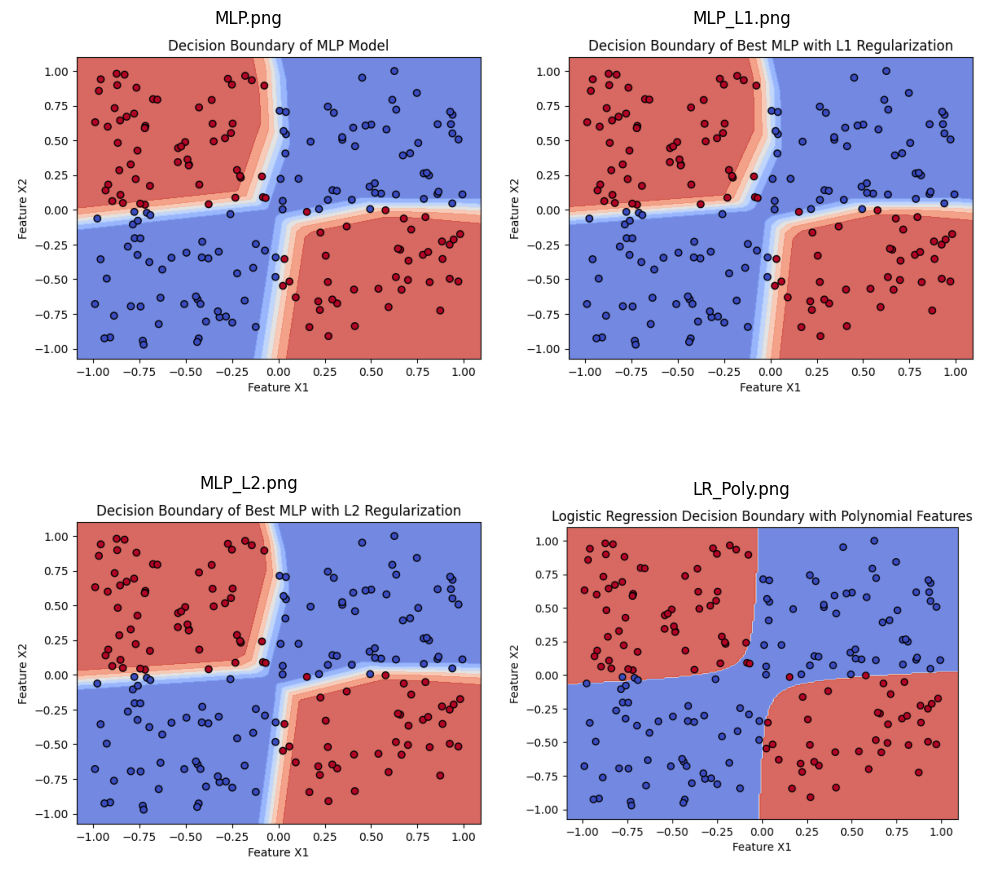

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the image file paths (update the file names as needed)
image_paths = [
    '/content/MLP.png',  # Replace with your actual image paths
    '/content/MLP_L1.png',
    '/content/MLP_L2.png',
    '/content/LR_Poly.png'
]

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Load and plot each image
for ax, image_path in zip(axs, image_paths):
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.axis('off')  # Hide axes
    ax.set_title(image_path.split('/')[-1])  # Set title as image name

# Adjust layout
plt.tight_layout()
plt.show()


> The Multi-Layer Perceptron (MLP) outperformed logistic regression with polynomial features on the XOR dataset, achieving a lower validation loss of **0.0765** and a higher test accuracy of **0.9750** compared to the logistic regression's best validation loss of **0.1918** and test accuracy of **0.9700**. The MLP's ability to capture complex, non-linear relationships allowed it to learn a more intricate decision boundary, while the logistic regression model struggled to fit the data effectively, even with polynomial features. Both models benefited from small regularization penalties to prevent overfitting.

3) Train on MNIST dataset using an MLP. The original training dataset contains 60,000 images and test contains 10,000 images. If you are short on compute, use a stratified subset of a smaller number of images. But, the test set remains the same 10,000 images. Compare against RF and Logistic Regression models.  The metrics can be: F1-score, confusion matrix. What do you observe? What all digits are commonly confused?

Let us assume your MLP has 30 neurons in first layer, 20 in second layer and then 10 finally for the output layer (corresponding to 10 classes). On the trained MLP, plot the t-SNE for the output from the layer containing 20 neurons for the 10 digits. Contrast this with the t-SNE for the same layer but for an untrained model. What do you conclude?

Now, use the trained MLP to predict on the Fashion-MNIST dataset. What do you observe? How do the embeddings (t-SNE viz for the second layer compare for MNIST and Fashion-MNIST images) [3 marks]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import mnist

# Load MNIST dataset directly
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape and normalize the data
X_train = X_train.reshape(-1, 28 * 28).astype("float32") / 255.0  # Flatten and normalize
X_test = X_test.reshape(-1, 28 * 28).astype("float32") / 255.0

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# Convert the data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Define the MLP model
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 30)  # First hidden layer with 30 neurons
        self.fc2 = nn.Linear(30, 20)       # Second hidden layer with 20 neurons
        self.fc3 = nn.Linear(20, 10)       # Output layer for 10 classes (digits 0-9)
        self.relu = nn.ReLU()               # Activation function

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input images
        x = self.fc1(x)              # Pass through the first layer
        x = self.relu(x)             # Apply ReLU activation
        x = self.fc2(x)              # Pass through the second layer
        x = self.relu(x)             # Apply ReLU activation
        x = self.fc3(x)              # Pass through the output layer
        return x                     # Return raw output (logits)

# Instantiate the model, define loss function and optimizer
model = MLPModel()
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Step 1: Train the model with early stopping
def train(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, criterion, optimizer, num_epochs=50, batch_size=64, patience=20):
    model.train()  # Set the model to training mode
    dataset_size = len(X_train_tensor)

    best_val_accuracy = 0.0  # To track the best validation accuracy
    epochs_without_improvement = 0  # Count epochs without improvement
    best_model_weights = None  # To save the best model weights

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i in range(0, dataset_size, batch_size):
            optimizer.zero_grad()  # Zero the gradients
            # Get the batch of data
            X_batch = X_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]
            outputs = model(X_batch)  # Forward pass
            loss = criterion(outputs, y_batch)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            running_loss += loss.item()  # Accumulate loss

        # Validate the model
        val_accuracy = evaluate(model, X_val_tensor, y_val_tensor)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/(dataset_size/batch_size):.4f}, Validation Accuracy: {val_accuracy:.2f}%')

        # Check for improvement
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_weights = model.state_dict()  # Save the best model weights
            epochs_without_improvement = 0  # Reset counter
        else:
            epochs_without_improvement += 1  # Increment counter

        # Early stopping
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

    # Load the best model weights
    if best_model_weights:
        model.load_state_dict(best_model_weights)
    return model

# Evaluate the model on validation/test set
def evaluate(model, X_tensor, y_tensor):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(X_tensor)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
        total += y_tensor.size(0)  # Total number of images
        correct += (predicted == y_tensor).sum().item()  # Correct predictions

    return 100 * correct / total  # Return accuracy

# Train the model
model = train(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, criterion, optimizer)

# Step 2: Evaluate the final model on the test set
test_accuracy = evaluate(model, X_test_tensor, y_test_tensor)
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Save the best model weights
torch.save(model.state_dict(), 'best_mlp_model_mnist.pth')
print("Best model saved to 'best_mlp_model_mnist.pth'.")

Epoch [1/50], Loss: 0.5294, Validation Accuracy: 91.33%
Epoch [2/50], Loss: 0.2672, Validation Accuracy: 92.97%
Epoch [3/50], Loss: 0.2221, Validation Accuracy: 93.93%
Epoch [4/50], Loss: 0.1923, Validation Accuracy: 94.47%
Epoch [5/50], Loss: 0.1715, Validation Accuracy: 95.06%
Epoch [6/50], Loss: 0.1553, Validation Accuracy: 95.32%
Epoch [7/50], Loss: 0.1426, Validation Accuracy: 95.51%
Epoch [8/50], Loss: 0.1324, Validation Accuracy: 95.66%
Epoch [9/50], Loss: 0.1241, Validation Accuracy: 95.73%
Epoch [10/50], Loss: 0.1167, Validation Accuracy: 95.81%
Epoch [11/50], Loss: 0.1099, Validation Accuracy: 95.87%
Epoch [12/50], Loss: 0.1037, Validation Accuracy: 95.96%
Epoch [13/50], Loss: 0.0980, Validation Accuracy: 96.01%
Epoch [14/50], Loss: 0.0930, Validation Accuracy: 96.02%
Epoch [15/50], Loss: 0.0882, Validation Accuracy: 96.06%
Epoch [16/50], Loss: 0.0839, Validation Accuracy: 95.99%
Epoch [17/50], Loss: 0.0796, Validation Accuracy: 95.88%
Epoch [18/50], Loss: 0.0757, Validation 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

# Load and preprocess the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 28 * 28).astype("float32") / 255.0  # Flatten and normalize
X_test = X_test.reshape(-1, 28 * 28).astype("float32") / 255.0
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Define the MLP model
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate model, loss function, and optimizer
mlp_model = MLPModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Training function with early stopping and checkpointing based on validation loss
def train_mlp_with_early_stopping(model, X_train, y_train, X_val, y_val, criterion, optimizer, num_epochs=200, batch_size=64, patience=20):
    model.train()
    best_val_loss = float('inf')
    best_model_weights = None
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()  # Ensure model is in training mode

        # Mini-batch training
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate validation loss
        val_loss = evaluate_loss(model, X_val, y_val, criterion)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / (len(X_train) // batch_size):.4f}, Validation Loss: {val_loss:.4f}')

        # Save best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict().copy()  # Copy weights for the best model
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Early stopping
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

    # Load best model weights
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    # Save the best model to disk
    torch.save(model.state_dict(), 'best_mlp_model_mnist.pth')
    print("Best model saved to 'best_mlp_model_mnist.pth' with validation loss:", best_val_loss)

    # Print model summary
    print("\nModel Summary:")
    for name, param in model.named_parameters():
        print(f"{name}: {param.size()}")

    return model

# Evaluate function to calculate loss
def evaluate_loss(model, X, y, criterion):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        loss = criterion(outputs, y)
    return loss.item()

# Train the model with early stopping and checkpointing
train_mlp_with_early_stopping(mlp_model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, criterion, optimizer)

Epoch [1/200], Loss: 0.5254, Validation Loss: 0.2899
Epoch [2/200], Loss: 0.2629, Validation Loss: 0.2404
Epoch [3/200], Loss: 0.2194, Validation Loss: 0.2073
Epoch [4/200], Loss: 0.1900, Validation Loss: 0.1859
Epoch [5/200], Loss: 0.1675, Validation Loss: 0.1694
Epoch [6/200], Loss: 0.1496, Validation Loss: 0.1567
Epoch [7/200], Loss: 0.1351, Validation Loss: 0.1469
Epoch [8/200], Loss: 0.1229, Validation Loss: 0.1397
Epoch [9/200], Loss: 0.1124, Validation Loss: 0.1344
Epoch [10/200], Loss: 0.1036, Validation Loss: 0.1307
Epoch [11/200], Loss: 0.0960, Validation Loss: 0.1281
Epoch [12/200], Loss: 0.0891, Validation Loss: 0.1260
Epoch [13/200], Loss: 0.0833, Validation Loss: 0.1260
Epoch [14/200], Loss: 0.0779, Validation Loss: 0.1252
Epoch [15/200], Loss: 0.0730, Validation Loss: 0.1260
Epoch [16/200], Loss: 0.0685, Validation Loss: 0.1270
Epoch [17/200], Loss: 0.0646, Validation Loss: 0.1280
Epoch [18/200], Loss: 0.0609, Validation Loss: 0.1302
Epoch [19/200], Loss: 0.0573, Validat

MLPModel(
  (fc1): Linear(in_features=784, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
  (relu): ReLU()
)

In [3]:
print(len(X_test))

10000


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [6]:
# Evaluate function to calculate accuracy
def evaluate(model, X, y):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    return 100 * correct / total

Test Accuracy (MLP): 95.93%
F1 Score (MLP): 0.9589329681453134
Confusion Matrix (MLP):


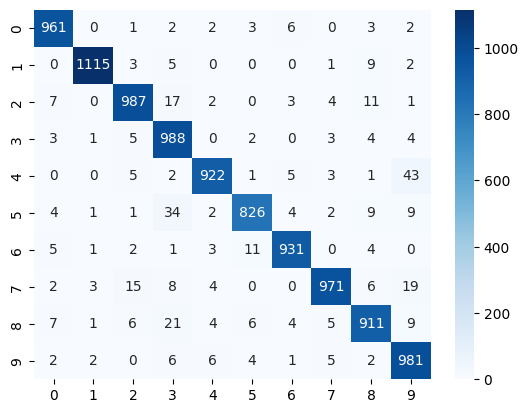

In [7]:
mlp_model = MLPModel()
mlp_model.load_state_dict(torch.load('best_mlp_model_mnist.pth',weights_only=True))

# Evaluate MLP on test data
test_accuracy = evaluate(mlp_model, X_test_tensor, y_test_tensor)
print(f'Test Accuracy (MLP): {test_accuracy:.2f}%')

# F1-score and Confusion matrix for MLP
y_test_pred_mlp = torch.max(mlp_model(X_test_tensor), 1)[1].cpu().numpy()
print("F1 Score (MLP):", f1_score(y_test, y_test_pred_mlp, average='macro'))
print("Confusion Matrix (MLP):")
sns.heatmap(confusion_matrix(y_test, y_test_pred_mlp), annot=True, fmt='d', cmap='Blues')
plt.show()

Test Accuracy (Random Forest): 0.97%
F1 Score (RF): 0.9674292714521
Confusion Matrix (RF):


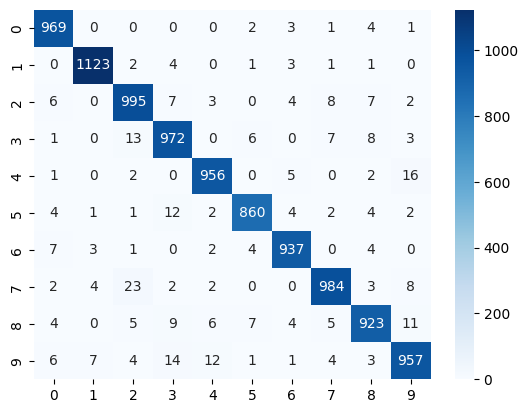

In [ ]:
# Train and evaluate Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_test_pred_rf = rf_model.predict(X_test)
test_accuracy_rf = rf_model.score(X_test, y_test)
print(f'Test Accuracy (Random Forest): {test_accuracy_rf:.2f}%')
print("F1 Score (RF):", f1_score(y_test, y_test_pred_rf, average='macro'))
print("Confusion Matrix (RF):")
sns.heatmap(confusion_matrix(y_test, y_test_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.show()

Test Accuracy (Logistic Regression): 0.92%
F1 Score (LogReg): 0.9167857003502835
Confusion Matrix (LogReg):


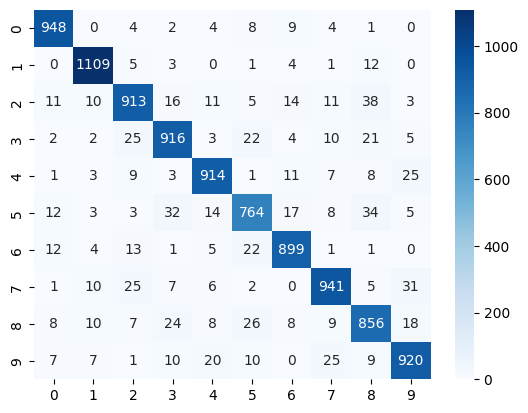

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the data for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate Logistic Regression
logreg_model = LogisticRegression(max_iter=500, solver='lbfgs')  # Increased max_iter
#lbfgs is a solver (an optimization algorithm) for finding optimal parameters for logistic regression.

logreg_model.fit(X_train_scaled, y_train)
y_test_pred_logreg = logreg_model.predict(X_test_scaled)
test_accuracy_logreg = logreg_model.score(X_test_scaled, y_test)
print(f'Test Accuracy (Logistic Regression): {test_accuracy_logreg:.2f}%')
print("F1 Score (LogReg):", f1_score(y_test, y_test_pred_logreg, average='macro'))

# Confusion Matrix
print("Confusion Matrix (LogReg):")
sns.heatmap(confusion_matrix(y_test, y_test_pred_logreg), annot=True, fmt='d', cmap='Blues')
plt.show()

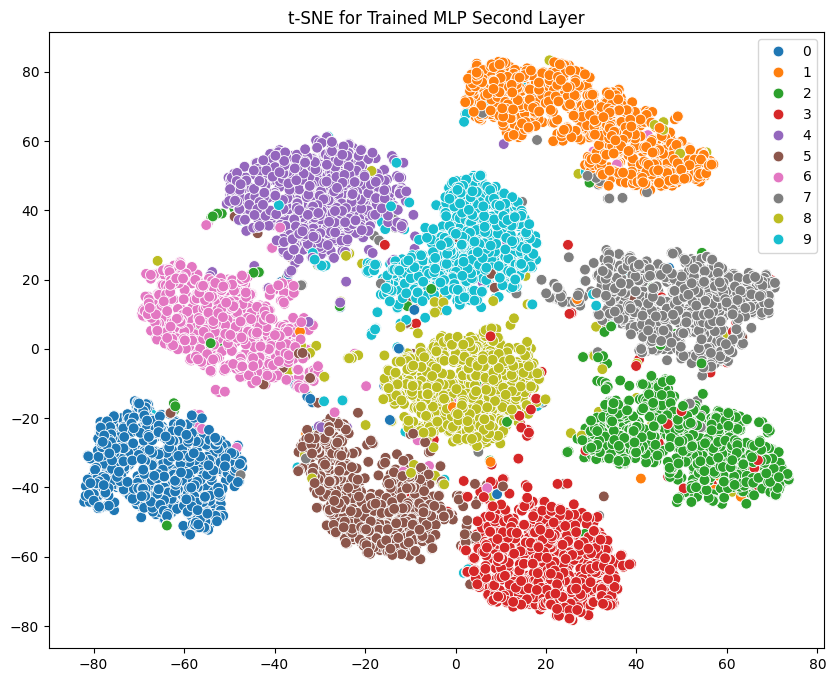

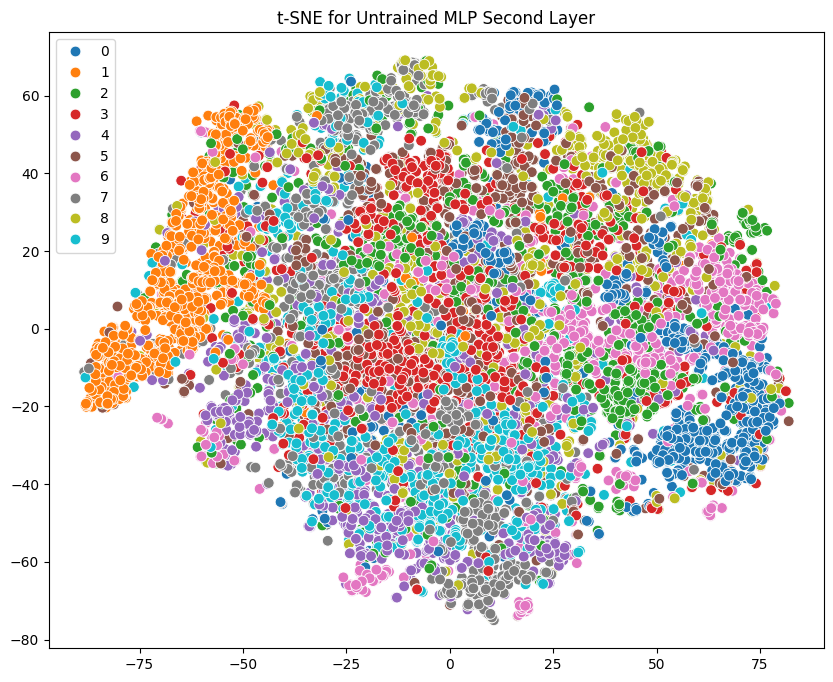

In [ ]:
# Extract second layer (20 neurons) from MLP for t-SNE
def extract_second_layer(model, X):
    model.eval()
    with torch.no_grad():
        x = model.relu(model.fc1(X))  # First layer + activation
        x = model.fc2(x)              # Second layer without activation
    return x.cpu().numpy()

# t-SNE visualization for trained MLP model
tsne = TSNE(n_components=2, random_state=42)
mlp_second_layer_train = extract_second_layer(mlp_model, X_test_tensor)
mlp_tsne = tsne.fit_transform(mlp_second_layer_train)

# Plot t-SNE for trained MLP
plt.figure(figsize=(10, 8))
sns.scatterplot(x=mlp_tsne[:, 0], y=mlp_tsne[:, 1], hue=y_test, palette="tab10", legend='full', s=60)
plt.title('t-SNE for Trained MLP Second Layer')
plt.show()

# t-SNE visualization for untrained MLP model
untrained_mlp_model = MLPModel()  # Untrained model
mlp_second_layer_untrained = extract_second_layer(untrained_mlp_model, X_test_tensor)
mlp_tsne_untrained = tsne.fit_transform(mlp_second_layer_untrained)

# Plot t-SNE for untrained MLP
plt.figure(figsize=(10, 8))
sns.scatterplot(x=mlp_tsne_untrained[:, 0], y=mlp_tsne_untrained[:, 1], hue=y_test, palette="tab10", legend='full', s=60)
plt.title('t-SNE for Untrained MLP Second Layer')
plt.show()

Test Accuracy (MLP) for fashion mnist: 11.51%


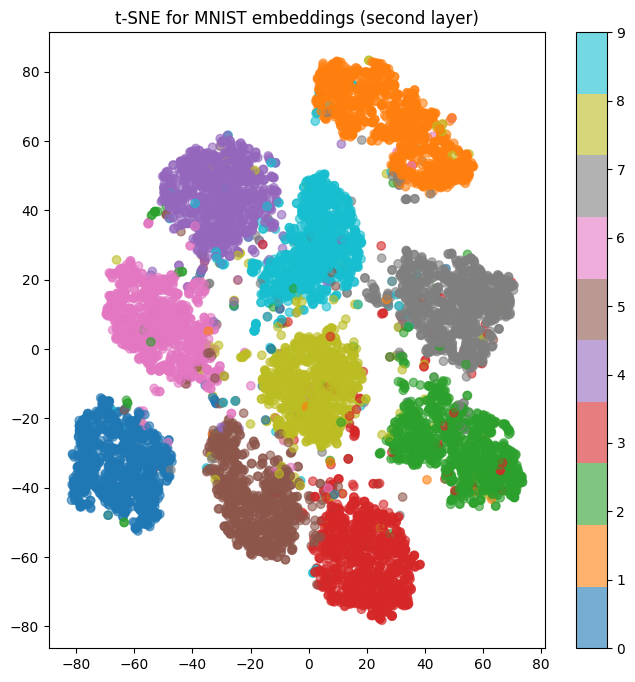

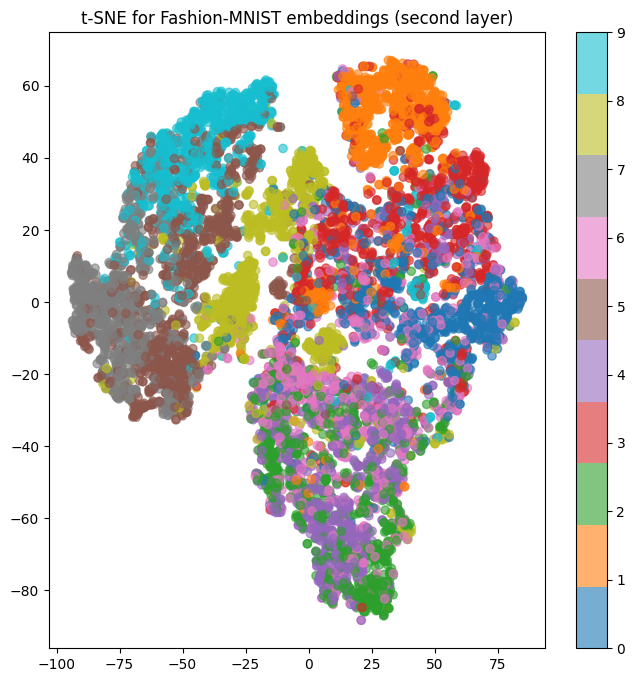

In [ ]:
import torch
import torch.nn as nn
from keras.datasets import fashion_mnist
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load the Fashion-MNIST dataset
(X_train_fashion, y_train_fashion), (X_test_fashion, y_test_fashion) = fashion_mnist.load_data()
X_test_fashion = X_test_fashion.reshape(-1, 28 * 28).astype("float32") / 255.0  # Flatten and normalize
X_test_fashion_tensor = torch.FloatTensor(X_test_fashion)
y_test_fashion_tensor = torch.LongTensor(y_test_fashion)

# Load the trained model
mlp_model = MLPModel()
mlp_model.load_state_dict(torch.load('best_mlp_model_mnist.pth',weights_only=False))
mlp_model.eval()

# Run evaluation on Fashion-MNIST
test_accuracy_f_mnist =evaluate(mlp_model, X_test_fashion_tensor, y_test_fashion_tensor)
print(f'Test Accuracy (MLP) for fashion mnist: {test_accuracy_f_mnist:.2f}%')

# Function to get embeddings from the second layer for t-SNE visualization
def get_layer_embeddings(model, X):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in range(X.size(0)):
            x = X[i].unsqueeze(0)
            x = model.relu(model.fc1(x))
            x = model.fc2(x)  # Output of the second layer
            embeddings.append(x.squeeze().numpy())
    return np.array(embeddings)

# Get embeddings for both MNIST and Fashion-MNIST
X_mnist_embeddings = get_layer_embeddings(mlp_model, X_test_tensor)
X_fashion_embeddings = get_layer_embeddings(mlp_model, X_test_fashion_tensor)

# t-SNE visualization
def plot_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap="tab10", alpha=0.6)
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

# Plot t-SNE for MNIST
plot_tsne(X_mnist_embeddings, y_test, title="t-SNE for MNIST embeddings (second layer)")

# Plot t-SNE for Fashion-MNIST
plot_tsne(X_fashion_embeddings, y_test_fashion, title="t-SNE for Fashion-MNIST embeddings (second layer)")


> labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

1) Refer to the notebook on generating names using next-character prediction and modify it for generating text using next-word prediction (You have to implement MLP based text generator. However, it is recommended to refer to Andrej Karpathy’s blog post on the Effectiveness of RNNs).

Visualize the embeddings using t-SNE if using more than 2 dimensions or using a scatter plot if using 2 dimensions and write your observations. Write a streamlit application that asks users for an input text, and it then predicts the next k words or lines. In the streamlit app, you should have controls for modifying context length, embedding dimension, activation function, random seed, etc. You can use any one of the datasets mentioned below.

	Hints:

a. For text-based datasets, you can remove special characters except “full stop (.)” so that it can be used to split sentences. However, you cannot ignore special characters for other datasets like for C++ code. You will have to treat text between newlines as a statement. To remove special characters from a line, you can use the following code snippet:

```
import re
line = re.sub('[^a-zA-Z0-9 \.]', '', line)
```



It will remove everything except alphanumeric characters, space and full-stop.

b. Convert the text to lowercase and use unique words to create the vocabulary.

c. To create X, and y pairs for training, you can use a similar approach used for next-character prediction. For example:

You will get something like “. . . . . ---> to” whenever there is a paragraph change.

d. You may have to use a larger embedding size for words. (For example: 32 or 64)

e. Use a similar model as used for next-character prediction. Here, you may have to increase the size of hidden layers. (For example, 1024).

f. For the streamlit app, no need to re-train the model based on the user input. Train two to three variants and accordingly give options to the user.

g. For visualizations, you may have to select words with relations like synonyms, antonyms, names and pronouns, verb and adverbs, words with no relations, and so on.

h. Think how you would handle the case where words provided by the user in streamlit are not in the vocabulary.

i. Use Google Colab or Kaggle for training (use maximum 500-1000 epochs). Start the assignment early, as training takes time.


In [ ]:
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Preprocess Text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9 \.]', '', text)  # Remove unwanted characters except full stop
    return text

# Load and preprocess the text data
with open("/content/part1.txt", "r") as file:
    text = file.read()

cleaned_text = preprocess_text(text)

# Split text into paragraphs
paragraph_text = cleaned_text.split('\n')
paragraph_text = [s.strip() for s in paragraph_text if s.strip()]

print(paragraph_text[:500])

# Tokenization and Vocabulary Creation
all_words = ' '.join(paragraph_text).split()
vocab = sorted(set(all_words))
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}
vocab_size = len(vocab)

print(word2idx)
print(idx2word)
print(len(word2idx))
print(len(idx2word))

['anyone can see theyre not the same by the number of people who are smart but not very wise.  and yet intelligence and wisdom do seem related.  howwhat is wisdom  id say its knowing what to do in a lot of situations.  im not trying to make a deep point here about the true nature of wisdom just to figure out how we use the word.  a wise person is someone who usually knows the right thing to do.and yet isnt being smart also knowing what to do in certain situations  for example knowing what to do when the teacher tells your elementary school class to add all the numbers from 1 to 100 some say wisdom and intelligence apply to different types of problemswisdom to human problems and intelligence to abstract ones.  but that isnt true.  some wisdom has nothing to do with people for example the wisdom of the engineer who knows certain structures are less prone to failure than others.  and certainly smart people can find clever solutions to human problems as well as abstract ones.  another popu

In [ ]:
import json

# Save word2idx to vocab.json
vocab_path = "/content/vocab.json"
with open(vocab_path, 'w') as f:
    json.dump(word2idx, f)

print(f"Vocabulary saved to {vocab_path}")


Vocabulary saved to /content/vocab.json


In [ ]:
# Step 2: Create Input-Output Pairs with Padding and Sliding Window
block_size = 5
X, Y = [], []

count = 0
for paragraph in paragraph_text:
    words = paragraph.split()
    context = [0] * block_size  # Start with initial padding for each paragraph
    for word in words + ['.']:  # Add stop word at the end of each paragraph
        ix = word2idx.get(word, 0)  # Map to index, using 0 if word is unknown
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]  # Slide context window by 1
        if(count<10):
          count = count+1
          print(f"{context} --> {word}")
# Convert data to PyTorch tensors
X = torch.tensor(X, dtype=torch.long).to(device)
Y = torch.tensor(Y, dtype=torch.long).to(device)

[0, 0, 0, 0, 1316] --> anyone
[0, 0, 0, 1316, 2665] --> can
[0, 0, 1316, 2665, 14369] --> see
[0, 1316, 2665, 14369, 16380] --> theyre
[1316, 2665, 14369, 16380, 11143] --> not
[2665, 14369, 16380, 11143, 16267] --> the
[14369, 16380, 11143, 16267, 14146] --> same
[16380, 11143, 16267, 14146, 2598] --> by
[11143, 16267, 14146, 2598, 16267] --> the
[16267, 14146, 2598, 16267, 11225] --> number


In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([272376, 5]), torch.int64, torch.Size([272376]), torch.int64)

In [ ]:
# Step 3: Define Dataset and DataLoader
class TextDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dataset = TextDataset(X, Y)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

217900
27237
27239


In [ ]:
# # Step 4: Define the Model
# class NextWordPredictor(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, block_size):
#         super(NextWordPredictor, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)  # Using LSTM for longer memory
#         self.fc = nn.Linear(hidden_dim, vocab_size)
#         self.block_size = block_size  # Store block size for reference

#     def forward(self, x):
#         x = self.embedding(x)
#         # print("Embedding Shape: ", x.shape)  # Should be (batch_size, block_size, embedding_dim)
#         _, (h_n, _) = self.lstm(x)
#         out = self.fc(h_n[-1])
#         return out

# embedding_dim = 64
# hidden_dim = 1024
# model = NextWordPredictor(vocab_size, embedding_dim, hidden_dim, block_size).to(device)


In [ ]:
class NextWordPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, block_size):
        super(NextWordPredictor, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Correct the input size of fc1 to embedding_dim * block_size
        self.fc1 = nn.Linear(embedding_dim * block_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.block_size = block_size

    def forward(self, x):
        x = self.embedding(x)  # Shape: (batch_size, block_size, embedding_dim)

        # Flatten only if x's dimensions are compatible with fc1
        if x.size(1) == self.block_size:
            x = x.view(x.size(0), -1)  # Flatten to (batch_size, block_size * embedding_dim)
        else:
            raise RuntimeError("Input size mismatch: ensure block_size matches during prediction.")

        x = torch.relu(self.fc1(x))  # Apply ReLU after the first linear layer
        out = self.fc2(x)  # Output logits for each vocabulary token
        return out

embedding_dim = 64
hidden_dim = 1024
model = NextWordPredictor(vocab_size, embedding_dim, hidden_dim, block_size).to(device)

In [ ]:
# Step 5: Training Setup with Checkpointing and Early Stopping
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_loss = float('inf')
patience = 10
early_stopping_counter = 0
checkpoint_path = "/content/drive/MyDrive/checkpoint/best_model.pth"

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    for batch_idx, (X_batch, Y_batch) in enumerate(train_loader):
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, Y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Print training progress every few batches
        if (batch_idx + 1) % 100 == 0:
            avg_loss = train_loss / (batch_idx + 1)
            print(f"Training - Batch {batch_idx + 1}/{len(train_loader)}, Loss: {avg_loss:.4f}")

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, Y_batch)
            val_loss += loss.item()

            _, predicted = torch.max(output, 1)  # Get the index of the max log-probability
            correct_predictions += (predicted == Y_batch).sum().item()
            total_predictions += Y_batch.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_predictions / total_predictions

    # Print overall epoch results
    print(f"Epoch {epoch + 1} Summary: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early Stopping and Checkpointing
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), checkpoint_path)
        early_stopping_counter = 0
        print("Validation loss improved. Model saved.")
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered")
        break

# Load the best model
model.load_state_dict(torch.load(checkpoint_path,weights_only=True))

# Step 6: Prediction Function
def predict_next_word(model, seed_text, num_words=1):
    model.eval()
    words = seed_text.lower().split()

    for _ in range(num_words):
        input_seq = [word2idx.get(word, 0) for word in words[-block_size:]]

        # Ensure the input is padded or trimmed to match block_size
        input_seq = input_seq + [0] * (block_size - len(input_seq))
        input_seq = input_seq[:block_size]

        input_seq = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_seq)
            predicted_idx = output.argmax(dim=1).item()

        next_word = idx2word.get(predicted_idx, "<UNK>")
        words.append(next_word)

    return ' '.join(words)

# Example usage
seed_text = "once upon a time"
print("Generated text:", predict_next_word(model, seed_text, num_words=5))



Epoch 1/100
Training - Batch 100/3405, Loss: 6.7394
Training - Batch 200/3405, Loss: 6.7262
Training - Batch 300/3405, Loss: 6.7464
Training - Batch 400/3405, Loss: 6.7501
Training - Batch 500/3405, Loss: 6.7535
Training - Batch 600/3405, Loss: 6.7566
Training - Batch 700/3405, Loss: 6.7523
Training - Batch 800/3405, Loss: 6.7557
Training - Batch 900/3405, Loss: 6.7484
Training - Batch 1000/3405, Loss: 6.7472
Training - Batch 1100/3405, Loss: 6.7483
Training - Batch 1200/3405, Loss: 6.7433
Training - Batch 1300/3405, Loss: 6.7466
Training - Batch 1400/3405, Loss: 6.7437
Training - Batch 1500/3405, Loss: 6.7412
Training - Batch 1600/3405, Loss: 6.7401
Training - Batch 1700/3405, Loss: 6.7379
Training - Batch 1800/3405, Loss: 6.7375
Training - Batch 1900/3405, Loss: 6.7365
Training - Batch 2000/3405, Loss: 6.7321
Training - Batch 2100/3405, Loss: 6.7313
Training - Batch 2200/3405, Loss: 6.7304
Training - Batch 2300/3405, Loss: 6.7298
Training - Batch 2400/3405, Loss: 6.7270
Training - B

> Below code is storing model state for each epoch.

In [ ]:
# Evaluate on the test set
model.eval()
test_loss = 0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        output = model(X_batch)
        loss = criterion(output, Y_batch)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(output, 1)  # Get the index of the max log-probability
        correct_predictions += (predicted == Y_batch).sum().item()
        total_predictions += Y_batch.size(0)

# Calculate average loss and accuracy
test_loss /= len(test_loader)
test_accuracy = correct_predictions / total_predictions

print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.4f}")

Final Test Loss: 5.9384, Final Test Accuracy: 0.1438


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Words not in vocabulary: ['joyful', 'Alice', 'banana']
Words in vocabulary: ['happy', 'sad', 'angry', 'run', 'quickly', 'slow', 'she', 'mountain']
Total words in vocabulary: 8


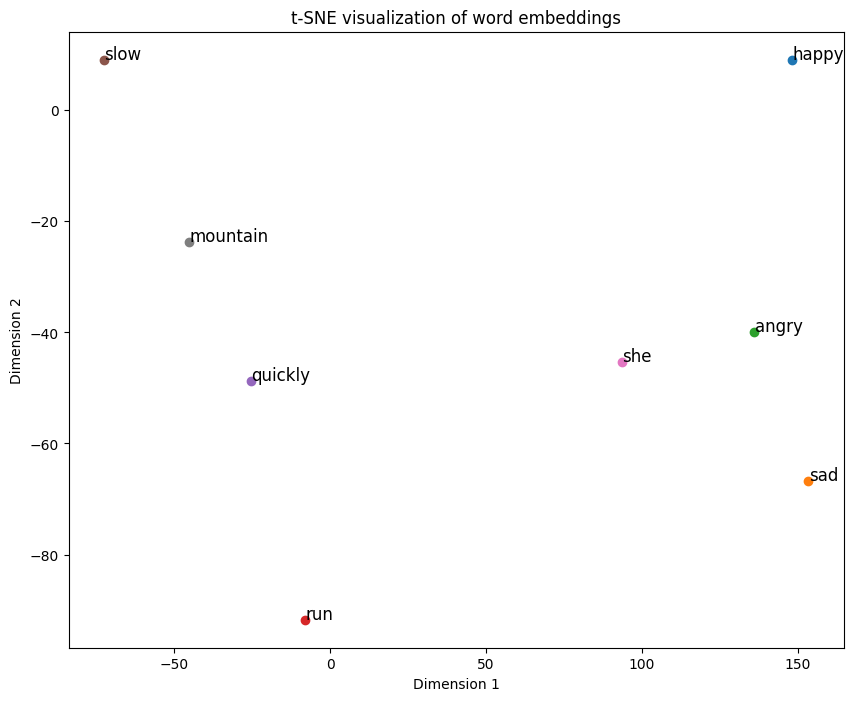

In [ ]:
import re
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import json

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Load the vocabulary
def load_vocab(vocab_path):
    with open(vocab_path, 'r') as f:
        vocab = json.load(f)
    return vocab

# Load vocabulary
vocab = load_vocab('vocab.json')  # Adjust the path if necessary
word2idx = vocab
idx2word = {idx: word for word, idx in word2idx.items()}
vocab_size = len(vocab)

# Define the model class (same as your training script)
class NextWordPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, block_size):
        super(NextWordPredictor, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * block_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.block_size = block_size

    def forward(self, x):
        x = self.embedding(x)  # Shape: (batch_size, block_size, embedding_dim)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, block_size * embedding_dim)
        x = torch.relu(self.fc1(x))
        out = self.fc2(x)
        return out

# Initialize and load the model
embedding_dim = 64
hidden_dim = 1024
block_size = 3
model = NextWordPredictor(vocab_size, embedding_dim, hidden_dim, block_size).to(device)
model.load_state_dict(torch.load("/content/best_model_0.pth", map_location=device,weights_only=True))  # Path to your saved model
model.eval()

# Define words for visualization with known relations
words_to_visualize = ["happy", "joyful", "sad", "angry", "run", "quickly", "slow", "Alice", "she", "mountain", "banana"]

# Check and print words not in the vocabulary
missing_words = [word for word in words_to_visualize if word not in word2idx]
print(f"Words not in vocabulary: {missing_words}")

# Check and print which words are in the vocabulary
words_in_vocab = [word for word in words_to_visualize if word in word2idx]
print(f"Words in vocabulary: {words_in_vocab}")

# Print the number of words in vocabulary and missing words
print(f"Total words in vocabulary: {len(words_in_vocab)}")

# Retrieve indices for words that are in the vocabulary
word_indices = [word2idx[word] for word in words_in_vocab]

# Extract the embeddings for words present in vocabulary
with torch.no_grad():
    word_embeddings = model.embedding(torch.tensor(word_indices).to(device)).cpu().numpy()

# Use t-SNE to reduce embeddings to 2D space
tsne = TSNE(n_components=2, random_state=0, perplexity=2)
word_embeddings_2d = tsne.fit_transform(word_embeddings)

# Plot the embeddings
plt.figure(figsize=(10, 8))
for i, word in enumerate(words_in_vocab):  # Using only words in vocab
    plt.scatter(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1])
    plt.text(word_embeddings_2d[i, 0] + 0.1, word_embeddings_2d[i, 1] + 0.1, word, fontsize=12)

plt.title("t-SNE visualization of word embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


t-SNE (t-distributed Stochastic Neighbor Embedding)

Words in vocabulary: ['happy', 'sad', 'angry', 'excited', 'bored', 'run', 'walk', 'jump', 'fly', 'sit', 'quick', 'slow', 'beautiful', 'ugly', 'bright', 'dark', 'mountain', 'river', 'apple']


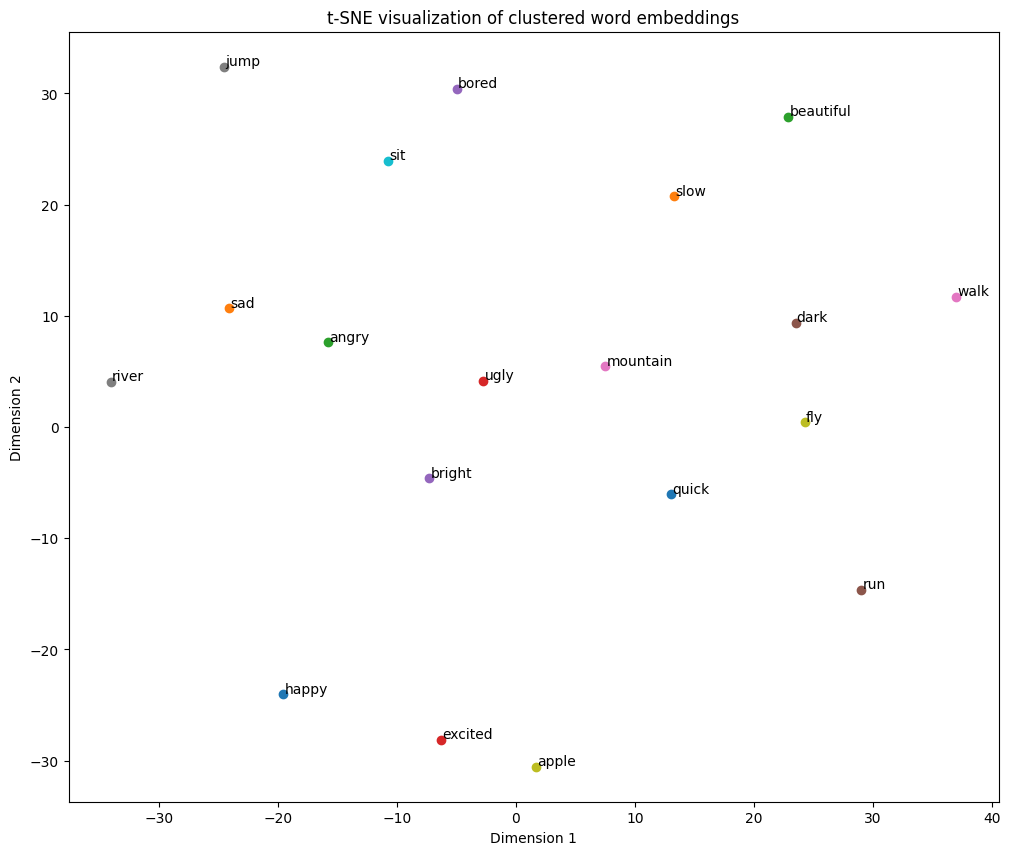

In [ ]:
import re
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import json

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Load the vocabulary
def load_vocab(vocab_path):
    with open(vocab_path, 'r') as f:
        vocab = json.load(f)
    return vocab

# Load vocabulary
vocab = load_vocab('vocab.json')  # Adjust the path if necessary
word2idx = vocab
idx2word = {idx: word for word, idx in word2idx.items()}
vocab_size = len(vocab)

# Define the model class (same as your training script)
class NextWordPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, block_size):
        super(NextWordPredictor, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * block_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.block_size = block_size

    def forward(self, x):
        x = self.embedding(x)  # Shape: (batch_size, block_size, embedding_dim)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, block_size * embedding_dim)
        x = torch.relu(self.fc1(x))
        out = self.fc2(x)
        return out

# Initialize and load the model
embedding_dim = 64
hidden_dim = 1024
block_size = 3
model = NextWordPredictor(vocab_size, embedding_dim, hidden_dim, block_size).to(device)
model.load_state_dict(torch.load("/content/best_model_0.pth", map_location=device, weights_only=True))  # Path to your saved model
model.eval()

# Define clusters of related words
clusters = {
    "emotions": ["happy", "joyful", "sad", "angry", "excited", "bored"],
    "actions": ["run", "walk", "jump", "swim", "fly", "sit"],
    "adjectives": ["quick", "slow", "beautiful", "ugly", "bright", "dark"],
    "nouns": ["Alice", "Bob", "mountain", "river", "banana", "apple"],
}

# Flatten the list of clusters for visualization
selected_words = [word for group in clusters.values() for word in group]

# Check which words are in the vocabulary
words_in_vocab = [word for word in selected_words if word in word2idx]
print(f"Words in vocabulary: {words_in_vocab}")

# Retrieve indices for words that are in the vocabulary
word_indices = [word2idx[word] for word in words_in_vocab]

# Extract the embeddings for the selected words
with torch.no_grad():
    word_embeddings = model.embedding(torch.tensor(word_indices).to(device)).cpu().numpy()

# Use t-SNE to reduce embeddings to 2D space
tsne = TSNE(n_components=2, random_state=0, perplexity=5)
word_embeddings_2d = tsne.fit_transform(word_embeddings)

# Plot the embeddings
plt.figure(figsize=(12, 10))
for i, word in enumerate(words_in_vocab):  # Using only words in vocab
    plt.scatter(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1])
    plt.text(word_embeddings_2d[i, 0] + 0.1, word_embeddings_2d[i, 1] + 0.1, word, fontsize=10)

plt.title("t-SNE visualization of clustered word embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()